# Logit Models
This notebook replicates the random forest models by using logit regression. Four models are implemented namely the rebel visibility, the rebel strength, the state capacity and the baseline model. Results are investigated with regression tables and p-values. In addition, coefficient distributions are obtained in bootstrapping and subsequently plotted in box plots and ridgeline plots. This serves to circumvent shortcomings of null-hypothesis significance testing.  


In [1]:
### Load libraries -------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np
import os
import yaml

# Logit regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLarsIC
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import log_loss

# Cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss
import sklearn.metrics as metrics

# Pandas parameters
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', 2000)
#pd.set_option('display.max_columns', 500)

In [2]:
### Define plot parameters ------
plt.rcParams["font.family"] = "garamond"
plt.rcParams.update({'font.size': 22})
rcParams.update({'figure.autolayout': True})

In [3]:
### Define plot parameters for box plots --------
medianprops = dict(linestyle='-', linewidth=1, color='black')
meanprops = dict(markerfacecolor='black', markeredgecolor="black")
boxprops = dict(linestyle='-', linewidth=1)

In [4]:
### Define plot parameters for sns plots --------
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font='garamond', font_scale=1)

In [5]:
### Define out paths ------

# check if out path exists, if it does not exists add the path
if not os.path.exists('C:\\Users\\frank\\Desktop\\master_thesis_out'):
    os.makedirs('C:\\Users\\frank\\Desktop\\master_thesis_out')

# add subfolders for the out path
out_paths = {
    "desciptive_plots_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_plots_outcome',
    "desciptive_tables_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_tables_outcome',
    "data": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data',
    "imp": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data\imp',
    "out": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out',
    "pdplots": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\pdplots',
    "plot_ALE": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\plot_ALE',
    "importance": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\importance',
    "evaluation": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\evaluation',
    "reg_tab": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\\reg_tab',
    "box_plot": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\\box_plot',
}

for key, val in out_paths.items():
    if not os.path.exists(val):
        os.makedirs(val)
        
out_paths["imp"]

'C:\\Users\\frank\\Desktop\\master_thesis_out\\data\\imp'

In [6]:
### Load data -----
df = pd.read_csv(os.path.join(out_paths["data"], "df_imp_1_onset.csv")) ### <----- change to use other imputed datasets
#df = pd.read_csv(os.path.join(out_paths["data"], "df_imp_simple_interpolated_onset.csv"))
print(len(df))
df.head(3)

2065


,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,gov_qual,milexp_in,milper_in,polity2,internet_use,active_year_lag,active_year_onset,active_year_onset_drop,active_roll,civil_war_dummy
0,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.813994,1.207825,-6.0,4.260658,0.0,0,0,0,0
1,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.840000,0.520000,-6.0,0.000000,0.0,1,1,1,0
2,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.370370,1.520000,0.520000,-6.0,0.000000,1.0,0,0,1,0


In [7]:
### Which variables are in data -------------
for col in df.columns: 
    print(col)

year
StateAbb
ccode
cname
side_a
side_a_new_id
side_b
side_b_new_id
dyad_name
dyad_new_id
active_year
best
high
low
foundloc
foundyear
foundmo
foundday
fightyear
fightmo
fightday
goalnominal
goalindep
goalauto
goalrights
goalrep
goalchange
goaldem
goalother
goalnote
ideology
ideolcom
ideolleft
ideolright
ideolnat
ideolanti
ideolrel
ideoloth
ideolnote
religious
religion
ethnic
ethnicity
preorg
preorgno
preorgreb
preorgter
preorgpar
preorgmvt
preorgyou
preorglab
preorgmil
preorggov
preorgfmr
preorgrel
preorgfor
preorgref
preorgeth
preorgoth
preorgname
merger
splinter
splinterUCDP
foundloc_cat
foundloc_cat_lab
foundloc_cat_cat_lab
age_active
goal_territory
goal_gov_represent
goal_gov_replace
ideo_left
ideo_right
ideo_anti_system
ideo_religious
ident_religious
parent_undefined
ccode_wb
goal_total
ideo_total
foundloc_cat_cat
age_formation
ident_ethnicity
parent_splinter_nonstate
parent_splinter_state
parent_civil_society
parent_merger
oil
forest_cov
rural
terrain
gov_qual
milexp_in
milper_i

In [8]:
### Open yaml file to import feature lists --------
# I specified a yaml file to import variable lists, this serves to shorten the notebook
with open('C:\\Users\\frank\\Desktop\\master_thesis\\feature_lists.yaml') as file:
    feat_list = yaml.load(file, Loader=yaml.FullLoader)

feat_rebel_visibility = feat_list["rebel_visibility"]
feat_social_networks = feat_list["social_networks_short_log"]
feat_state_capacity = feat_list["state_capacity"]
feat_natural_resources = feat_list["natural_resources_log"]

In [9]:
### Make a dictionary with fancy names of variables to import into functions  -----
dict_feat_names = {
  "foundloc_cat_cat": "Location of Rebel Group Foundation to Capital",
  "terrain": "Terrain Ruggedness",
  "forest_cov": "Forest Coverage ",
  "rural": "Rural Population ",
  "oil": "Oil Rents",
  "oil_log": "Oil Rents (log)",
  "ident_ethnicity": "Ethnicity  (Identity)",
  "parent_splinter_nonstate": "Splinter Non-State (Pre-existing Organization)",
  "parent_splinter_state": "Splinter State (Pre-existing Organization)",
  "parent_civil_society": "Civil Society (Pre-existing Organization)",
  "parent_merger": "Merger (Pre-existing Organization)",
  "civil_war_dummy": "Transition to Civil War", 
  "active_year_lag": "Transition to Civil Conflict (lag)",
  "gov_qual": "Quality of Government",
  "milexp_in": "Military Expenditure Index",
  "milper_in": "Military Personnel Index",
  "polity2": "Combined Polity Score", 
  "polity2_sqr": "Combined Polity Score (sqr)", 
  'internet_use': "Internet Usage",
  'internet_use_log': "Internet Usage (log)",
  'internet_use_log_sqr': "Internet Usage (log) (sqr)",
  "age_formation": "Age of Rebel Group Since Foundation",
  "age_formation_sqr": "Age of Rebel Group Since Foundation (sqr)",
  "ideo_total": "Count of Ideologies",
  "goal_total": "Count of Goals",
  "Intercept": "Intercept",
  "age_formation_sqr_re": "Age of Rebel Group Since Foundation (sqr) (re)"
}


## Preparation
This section prepares the variables for the subsequent analysis. Two features are log transformed namely oil rents and Internet usage which are highly right-skewed. Consecutive years of armed conflict are dropped, and outcome and baseline variables are defined. The logit models need to be as similar as possible to the random forest specification to ensure comparability. 

In [10]:
### Log-transform oil rents and Internet usage features because they are extremely right skewed ----------
df["oil_log"] = np.log(df["oil"]+1)
df["internet_use_log"] = np.log(df["internet_use"]+1)

In [11]:
### Set country and year as multi index ------
df.set_index(['ccode_wb', 'dyad_new_id', 'year'], inplace=True)
df.head(4)

StateAbb  ccode cname              side_a  \
ccode_wb dyad_new_id year                                             
IRN      406         1989      IRN    630  Iran  Government of Iran   
                     1990      IRN    630  Iran  Government of Iran   
                     1991      IRN    630  Iran  Government of Iran   
                     1992      IRN    630  Iran  Government of Iran   

                           side_a_new_id side_b  side_b_new_id  \
ccode_wb dyad_new_id year                                        
IRN      406         1989            114   KDPI            164   
                     1990            114   KDPI            164   
                     1991            114   KDPI            164   
                     1992            114   KDPI            164   

                                           dyad_name  active_year  best  ...  \
ccode_wb dyad_new_id year                                                ...   
IRN      406         1989  Government of Iran - KDPI            0     0  ...   
                     1990  Government of Iran - KDPI            1    31  ...   
                     1991  Government of Iran - KDPI            0     0  ...   
                     1992  Government of Iran - KDPI            0     4  ...   

                           milper_in  polity2 internet_use  active_year_lag  \
ccode_wb dyad_new_id year                                                     
IRN      406         1989   1.207825     -6.0     4.260658              0.0   
                     1990   0.520000     -6.0     0.000000              0.0   
                     1991   0.520000     -6.0     0.000000              1.0   
                     1992   0.510000     -6.0     0.000000              0.0   

                           active_year_onset  active_year_onset_drop  \
ccode_wb dyad_new_id year                                              
IRN      406         1989                  0                       0   
                     1990                  1                       1   
                     1991                  0                       0   
                     1992                  0                       0   

                           active_roll  civil_war_dummy   oil_log  \
ccode_wb dyad_new_id year                                           
IRN      406         1989            0                0  2.783226   
                     1990            1                0  3.112403   
                     1991            1                0  2.385613   
                     1992            1                0  2.355806   

                          internet_use_log  
ccode_wb dyad_new_id year                   
IRN      406         1989         1.660256  
                     1990         0.000000  
                     1991         0.000000  
                     1992         0.000000  

[4 rows x 99 columns]

In [12]:
### Define outcome variable ----
#y = ["active_year_onset"]
y = ["active_year_onset_drop"]

In [13]:
### Make subset of data according to onset variable - drop observations with active_year_onset_drop=-99 ------
df_s = df.loc[(df["active_year_onset_drop"]==0) | (df["active_year_onset_drop"]==1) ].copy()
print(len(df_s))
df_s["active_year_onset_drop"].unique()

1362


array([0, 1], dtype=int64)

In [14]:
### Define control variables -----
con = ['civil_war_dummy',
       'active_year_lag']

### Rebel Visibility Model
This section implements the rebel visibility model. This model includes the following variables: location of rebel group foundation to capital, age of the rebel group since foundation, forest coverage, percentage of rural population and terrain ruggedness.  As suggested by theory, age of the rebel group since foundation should have an inverted u-shaped relationship on the probability of transition to civil conflict. This is why I include a squared term in addition to the main effect. If the main effect is positive and the squared term negative, the model supports an inverted u-shaped association.

In [15]:
### Prepare data for statsmodels to double check results -----------------
df_s["age_formation_sqr"] = df_s["age_formation"] * (df_s["age_formation"]) # define squared term

# there was a convergence issue in statsmodels which is why I rescaled the quadratic term
# this is not that relevant since statsmodels are only used as a double check
# the analysis is focused on the scikit learn library which did not encounter this problem
df_s["age_formation_sqr_re"] = df_s["age_formation_sqr"]  / 100

df_rebel_visibility_logit = df_s[df_s.columns & feat_rebel_visibility + y + con + ["age_formation_sqr_re"]].copy()

In [16]:
### Get data for statsmodels to double check results  -------
y_rebel_visi_logit = df_rebel_visibility_logit['active_year_onset_drop'].copy()
x_rebel_visi_logit = df_rebel_visibility_logit.drop('active_year_onset_drop', axis = 1).copy()
#x_rebel_visi_logit = sm.add_constant(x_rebel_visi_logit.values) # add constant for statsmodels <-- to stop warning (but variable labels disappear)
x_rebel_visi_logit = sm.add_constant(x_rebel_visi_logit) # add constant for statsmodels

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
### Implement logit model for statsmodels to double check results  -------
logit_rebel_visi = sm.Logit(y_rebel_visi_logit, x_rebel_visi_logit)
logit_rebel_visi_r = logit_rebel_visi.fit(maxiter=1000,  # needs to be specified in order for the model to converge
                                        method='lbfgs', 
                                        cov_type='HC1') # robust standard errors
logit_rebel_visi_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     active_year_onset_drop   No. Observations:                 1362
Model:                              Logit   Df Residuals:                     1353
Method:                               MLE   Df Model:                            8
Date:                    Wed, 19 May 2021   Pseudo R-squ.:                  0.2189
Time:                            09:06:39   Log-Likelihood:                -619.15
converged:                           True   LL-Null:                       -792.66
Covariance Type:                      HC1   LLR p-value:                 3.926e-70
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3453      0.306      1.127      0.260      -0.255       0.946
foundloc_cat_cat        -0.1023      0.037     -2.764      0.006      -0.175      -0.030
age_formation           -0.0885      0.014     -6.301      0.000      -0.116      -0.061
forest_cov              -0.0042      0.004     -1.193      0.233      -0.011       0.003
rural                    0.0070      0.003      2.022      0.043       0.000       0.014
terrain                 -0.0011      0.001     -1.523      0.128      -0.003       0.000
active_year_lag        -43.0928      0.113   -381.132      0.000     -43.314     -42.871
civil_war_dummy         16.7275      0.224     74.679      0.000      16.289      17.167
age_formation_sqr_re     0.0988      0.029      3.419      0.001       0.042       0.155
========================================================================================

Possibly complete quasi-separation: A fraction 0.18 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [18]:
### Check parameters ----
logit_rebel_visi_r.params

const                    0.345303
foundloc_cat_cat        -0.102329
age_formation           -0.088493
forest_cov              -0.004185
rural                    0.007028
terrain                 -0.001111
active_year_lag        -43.092760
civil_war_dummy         16.727536
age_formation_sqr_re     0.098791
dtype: float64

In [19]:
### Prepare data for scikit learn -----
df_rebel_visibility_logit = df_s[df_s.columns & feat_rebel_visibility + y + con + ["age_formation_sqr"]].copy()

In [20]:
### Get data for scikit learn -----
y_rebel_visi_logit = df_rebel_visibility_logit['active_year_onset_drop'].copy()
x_rebel_visi_logit = df_rebel_visibility_logit.drop('active_year_onset_drop', axis = 1).copy()

In [21]:
### Estimate Model with Scikit learn ----
# Scikit learn cannot implement robust standard errors nor p-values
model = LogisticRegression(max_iter=1000, # set to 1000 to avoid convergence issues
                           solver='lbfgs',
                           #penalty='none' # to get similar results to statsmodels
                          )
logit_scikit_rebel_visi = model.fit(x_rebel_visi_logit, y_rebel_visi_logit)

# print coefficients
print(logit_scikit_rebel_visi.intercept_)
logit_scikit_rebel_visi.coef_

[0.56766067]


array([[-1.13114557e-01, -9.15706162e-02, -4.81702441e-03,
         5.28491152e-03, -1.23885097e-03, -3.56016029e+00,
         2.55837347e+00,  1.02978470e-03]])

In [22]:
### Get regression table for scikit learn with z statistics and p-values -----
# Source of the code: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance

def logit_pvalue(model, 
                 x): 
    preds = model.predict_proba(x) # get predictions
    n_cases = len(preds) # number of observation
    n_coef = len(model.coef_[0]) + 1 # number of coefficient + 1
    betas = np.concatenate([model.intercept_, model.coef_[0]]) # get coefficients
    x_vals_arr = np.matrix(np.insert(np.array(x), 0, 1, axis = 1)) # copy x-values into array
    matrix = np.zeros((n_coef, n_coef)) # make empty matrix based on number of coefficients + 1
    
    for i in range(n_cases):
        matrix = matrix + np.dot(np.transpose(x_vals_arr[i, :]), x_vals_arr[i, :]) * preds[i, 1] * preds[i, 0] # variance-covariance matrix 
    vcov_matrix = np.linalg.inv(np.matrix(matrix)) # inverse variance-covariance matrix 
    standard_errors = np.sqrt(np.diag(vcov_matrix)) # calculate standard errors
    t_val =  betas/standard_errors  # get t values, divide betas by standard errors
    p_val = (1 - norm.cdf(abs(t_val))) * 2 # calculate p-values from normal cumulative distribution function
    
    regtab = pd.DataFrame()
    regtab["Coefficients"],regtab["Standard Errors"],regtab["t Values"],regtab["p Values"] = [betas,standard_errors,t_val,p_val]
    return regtab

In [23]:
### Check order of x-variables ------
for i in x_rebel_visi_logit.columns:
    print(i)

foundloc_cat_cat
age_formation
forest_cov
rural
terrain
active_year_lag
civil_war_dummy
age_formation_sqr


In [24]:
### Make regression table for scikit learn with z statistics -----
pd.options.display.float_format = '{:.4f}'.format

# get regression table and insert variable names
reg_tab_rebel_visi = logit_pvalue(logit_scikit_rebel_visi, x_rebel_visi_logit)
reg_tab_rebel_visi.insert(0, "Var", ['Intercept', 
                                     'foundloc_cat_cat',
                                     "age_formation", 
                                     'forest_cov', 
                                     'rural', 
                                     'terrain', 
                                     'active_year_lag', 
                                     "civil_war_dummy",
                                     "age_formation_sqr"])
# sort coefficients
reg_tab_rebel_visi = reg_tab_rebel_visi.reindex([1, 2, 8, 3, 5, 4, 6, 7, 0])
reg_tab_rebel_visi = reg_tab_rebel_visi.reset_index(drop=True)

# add fancy names from dictionary
for row in reg_tab_rebel_visi.iterrows():
    feat=row[1][0]
    feat_long=dict_feat_names[feat]
    reg_tab_rebel_visi.loc[reg_tab_rebel_visi['Var'] == feat, 'Variable'] = feat_long
    
# save table
reg_tab_rebel_visi=reg_tab_rebel_visi.drop(['Var'], axis=1)
reg_tab_rebel_visi = reg_tab_rebel_visi[['Variable', "Coefficients", "Standard Errors", "t Values", "p Values"]]
reg_tab_rebel_visi.to_latex(os.path.join(out_paths["reg_tab"], f"_reg_tab_rebel_visi.tex"), index=False)
reg_tab_rebel_visi
# Comment: results of scikit learn are slightly different than statsmodels which originates from the penalty
# If penalty is set to none, the results are the same. However, I decided to use the default in scikit learn because
# the models would converge more smoothly

,Variable,Coefficients,Standard Errors,t Values,p Values
0,Location of Rebel Group Foundation to Capital,-0.1131,0.0350,-3.2315,0.0012
1,Age of Rebel Group Since Foundation,-0.0916,0.0137,-6.6882,0.0000
2,Age of Rebel Group Since Foundation (sqr),0.0010,0.0003,3.4698,0.0005
3,Forest Coverage,-0.0048,0.0035,-1.3583,0.1744
4,Terrain Ruggedness,-0.0012,0.0007,-1.6879,0.0914
5,Rural Population,0.0053,0.0033,1.6113,0.1071
6,Transition to Civil Conflict (lag),-3.5602,0.5828,-6.1092,0.0000
7,Transition to Civil War,2.5584,0.5572,4.5917,0.0000
8,Intercept,0.5677,0.2997,1.8944,0.0582


In [25]:
### Check order of x-variables ------
for i in x_rebel_visi_logit.columns:
    print(i)

foundloc_cat_cat
age_formation
forest_cov
rural
terrain
active_year_lag
civil_war_dummy
age_formation_sqr


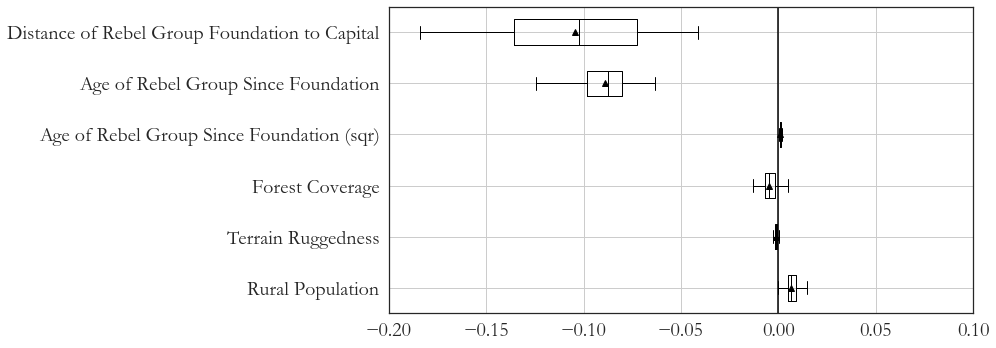

In [26]:
### Bootstrapping beta coefficients ------
# make empty dataset to store results
betas_all = pd.DataFrame()

# Step 1: initiate boostrapping
for i in range(1,100):
    model = LogisticRegression(max_iter=1000, 
                               solver='lbfgs',
                               #penalty='none'
                              )
    
    columns = ['foundloc_cat_cat', # name of columns in data
               "age_formation", 
               'forest_cov', 
               'rural', 
               'terrain', 
               'active_year_lag', 
               "civil_war_dummy", 
               "age_formation_sqr"]
    
    # draw bootstrapping sample and prepare x/y
    df_all_logit_reps = df_s[df_s.columns & feat_rebel_visibility + y + con + ["age_formation_sqr"]].sample(frac=1,replace=True,random_state=i)
    y_all_logit_reps = df_all_logit_reps['active_year_onset_drop'].copy()
    x_all_logit_reps = df_all_logit_reps.drop('active_year_onset_drop', axis = 1).copy()

    # calculate logit model and merge with pre-defined dataset
    logit_all_scikit = model.fit(x_all_logit_reps, y_all_logit_reps)
    coef = logit_all_scikit.coef_
    betas = pd.DataFrame(coef,columns=columns)
    betas_all = pd.concat([betas_all, betas])

# Step 2: subset results to only include variables of interest
betas_all_plot = betas_all[['rural', 
                            'terrain', 
                            'forest_cov',  
                            "age_formation_sqr", 
                            "age_formation", 
                            'foundloc_cat_cat']]

# Step 3: implement boxplot
fig = plt.figure(figsize=(14, 5))
ax = plt.axes()
bp=betas_all_plot.boxplot(vert=False, showmeans=True, medianprops=medianprops, meanprops=meanprops, boxprops=boxprops,
                      return_type='dict')  

# change colors of boxes, whiskers, medians, means
for box in bp['boxes']:
    box.set_color('black')   
for whis in bp['whiskers']:
    whis.set_color('black')
for median in bp['medians']:
    median.set_color('black')  
for means in bp['means']:
    means.set_color('black')

# change labels
labels = [lab.get_text() for lab in ax.get_yticklabels()]
labels[5] = 'Distance of Rebel Group Foundation to Capital'
labels[2] = 'Forest Coverage'
labels[0] = 'Rural Population'
labels[1] = 'Terrain Ruggedness'
labels[4] = 'Age of Rebel Group Since Foundation'
labels[3] = 'Age of Rebel Group Since Foundation (sqr)'

# set axis
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticks(np.arange(-0.2, 0.1, 0.05))
ax.tick_params(axis='x', labelsize=20)
plt.axvline(x=0, color='black', linestyle='-')

# Save plot 
fig.savefig(os.path.join(out_paths["box_plot"], f"_box_plot_rebel_visi.png"), dpi=100)

In [27]:
### Check results from bootstrapping  ------
betas_all_plot.head(1)

,rural,terrain,forest_cov,age_formation_sqr,age_formation,foundloc_cat_cat
0,0.0087,-0.0010,-0.0047,0.0009,-0.0848,-0.0718


In [28]:
### Make FacetGrid plot I - preparation -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# transpose data frame
betas_all_plot_melt = pd.melt(betas_all_plot, value_vars=['foundloc_cat_cat',
                                                          "age_formation",
                                                          "age_formation_sqr", 
                                                          'forest_cov', 
                                                          'terrain', 
                                                          'rural'])

# make dictionary with variable names
dict_names = {1: 'Distance of Rebel Group Foundation to Capital',
              2: 'Age of Rebel Group Since Foundation',
              3: 'Age of Rebel Group Since Foundation (sqr)',
              4: 'Forest Coverage',
              5: 'Terrain Ruggedness',
              6: 'Rural Population'}

# Get mean for the bootstrapping solutions and round
foundloc_cat_cat_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="foundloc_cat_cat"].mean())
foundloc_cat_cat_mean = round(foundloc_cat_cat_mean[0], 5)
age_formation_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="age_formation"].mean())
age_formation_mean = round(age_formation_mean[0], 5)
age_formation_sqr_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="age_formation_sqr"].mean())
age_formation_sqr_mean = round(age_formation_sqr_mean[0], 5)
forest_cov_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="forest_cov"].mean())
forest_cov_mean = round(forest_cov_mean[0], 5)
terrain_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="terrain"].mean())
terrain_mean = round(terrain_mean[0], 5)
rural_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="rural"].mean())
rural_mean = round(rural_mean[0], 5)

# save means in dictionary
dict_means = {1: foundloc_cat_cat_mean,
             2: age_formation_mean,
             3: age_formation_sqr_mean,
             4: forest_cov_mean,
             5: terrain_mean,
             6: rural_mean}

# get proportion of bootstrapping repetitions which have same sign than mean
#foundloc_cat_cat_props = (len(betas_all_plot.loc[betas_all_plot["foundloc_cat_cat"]<0])+1)/100 # negative
foundloc_cat_cat_props = round(100. * (betas_all_plot["foundloc_cat_cat"] < 0).sum() / len(betas_all_plot["foundloc_cat_cat"].index), 2) # negative
#age_formation_props = (len(betas_all_plot.loc[betas_all_plot["age_formation"]<0])+1)/100 # negative
age_formation_props = round(100. * (betas_all_plot["age_formation"] < 0).sum() / len(betas_all_plot["age_formation"].index), 2) # negative
#age_formation_sqr_props = (len(betas_all_plot.loc[betas_all_plot["age_formation_sqr"]>0])+1)/100 # positive
age_formation_sqr_props = round(100. * (betas_all_plot["age_formation_sqr"] >= 0).sum() / len(betas_all_plot["age_formation_sqr"].index), 2) # positive
#forest_cov_props = (len(betas_all_plot.loc[betas_all_plot["forest_cov"]<0])+1)/100 # negative
forest_cov_props = round(100. * (betas_all_plot["forest_cov"] < 0).sum() / len(betas_all_plot["forest_cov"].index), 2) # negative
#terrain_props = (len(betas_all_plot.loc[betas_all_plot["terrain"]<0])+1)/100 # negative
terrain_props = round(100. * (betas_all_plot["terrain"] < 0).sum() / len(betas_all_plot["terrain"].index), 2) # negative
#rural_props = (len(betas_all_plot.loc[betas_all_plot["rural"]>0])+1)/100 # positive
rural_props = round(100. * (betas_all_plot["rural"] >= 0).sum() / len(betas_all_plot["rural"].index), 2) # positive

# save proportions in dictionary
dict_props = {1: foundloc_cat_cat_props,
             2: age_formation_props,
             3: age_formation_sqr_props,
             4: forest_cov_props,
             5: terrain_props,
             6: rural_props}

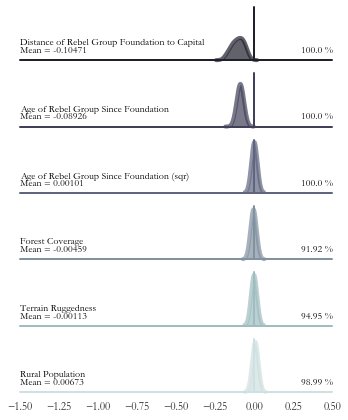

In [29]:
### Make FacetGrid plot II  - make plot -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# get colors
pal = sns.color_palette(palette='bone', n_colors=6)

# specify plot as facet grid
grid = sns.FacetGrid(betas_all_plot_melt, row='variable', hue='variable', aspect=5, height=1, palette=pal, xlim=[-1.5, 0.5])

# add density plots
grid.map(sns.kdeplot, 'value', clip_on=False,
       shade=True, alpha=0.7, lw=4, bw=.02)

# add line on x=0
grid.map(plt.axvline, x=0,
      lw=2, clip_on=False)

# decrease gap between plots
grid.fig.subplots_adjust(hspace=-0.3)

# add line for y=0
grid.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# add names of variables 
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-1.5, y=6, s=dict_names[i+1], fontsize=10,
            color="black")
    
# add means for bootstrap repetitions    
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-1.5, y=3, s=f"Mean = {dict_means[i+1]}", fontsize=10,
            color="black")
    
# add proportion of repetitions with same sign as mean    
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=0.3, y=3, s=f"{dict_props[i+1]} %", fontsize=10,
            color="black")
    
# remove axes, ticks, spines
grid.set_titles("")
grid.set(yticks=[])
grid.despine(bottom=True, left=True)

# save plot
plt.savefig(os.path.join(out_paths["box_plot"], f"_FacetGrid_rebel_visi.png"), dpi=700)

In [30]:
### Check mean values manually -----
print(betas_all_plot["rural"].mean())
print(betas_all_plot["terrain"].mean())
print(betas_all_plot["forest_cov"].mean())
print(betas_all_plot["age_formation_sqr"].mean())
print(betas_all_plot["age_formation"].mean())
print(betas_all_plot["foundloc_cat_cat"].mean())

0.006733551165738388
-0.001131552332348785
-0.0045867997254149355
0.0010060367616481934
-0.08925569693804677
-0.10470668127826004


In [31]:
### Check proportions manually ------
print(100. * (betas_all_plot["rural"] < 0).sum() / len(betas_all_plot["rural"].index))
print(100. * (betas_all_plot["rural"] >= 0).sum() / len(betas_all_plot["rural"].index))
print(100. * (betas_all_plot["terrain"] < 0).sum() / len(betas_all_plot["terrain"].index))
print(100. * (betas_all_plot["terrain"] >= 0).sum() / len(betas_all_plot["terrain"].index))
print(100. * (betas_all_plot["forest_cov"] < 0).sum() / len(betas_all_plot["forest_cov"].index))
print(100. * (betas_all_plot["forest_cov"] >= 0).sum() / len(betas_all_plot["forest_cov"].index))
print(100. * (betas_all_plot["age_formation_sqr"] < 0).sum() / len(betas_all_plot["age_formation_sqr"].index))
print(100. * (betas_all_plot["age_formation_sqr"] >= 0).sum() / len(betas_all_plot["age_formation_sqr"].index))
print(100. * (betas_all_plot["age_formation"] < 0).sum() / len(betas_all_plot["age_formation"].index))
print(100. * (betas_all_plot["age_formation"] >= 0).sum() / len(betas_all_plot["age_formation"].index))
print(100. * (betas_all_plot["foundloc_cat_cat"] < 0).sum() / len(betas_all_plot["foundloc_cat_cat"].index))
print(100. * (betas_all_plot["foundloc_cat_cat"] >= 0).sum() / len(betas_all_plot["foundloc_cat_cat"].index))

1.0101010101010102
98.98989898989899
94.94949494949495
5.05050505050505
91.91919191919192
8.080808080808081
0.0
100.0
100.0
0.0
100.0
0.0


### Rebel Strength
The following section implements the rebel strength  model which includes the following variables: count of goals, count of ideologies, ethnic identity, whether the rebel group originated from a non-state armed group, a state group, a merger, from a civil society organization, oil rents and Internet usage. In order to validate the inverted u-shaped relationship between Internet usage and civil conflict, a squared termed is also included. 

In [32]:
### Prepare data for statsmodels  -----
df_s["internet_use_log_sqr"] = df_s["internet_use_log"] * df_s["internet_use_log"] # define quadratic term
df_rebel_strength_logit = df_s[df_s.columns & feat_social_networks + feat_natural_resources + y + con + ["internet_use_log_sqr"]].copy()

In [33]:
### Get data for statsmodels  -----
y_rebel_strength_logit = df_rebel_strength_logit['active_year_onset_drop'].copy()
x_rebel_strength_logit = df_rebel_strength_logit.drop('active_year_onset_drop', axis = 1).copy()
#x_rebel_strength_logit = sm.add_constant(x_rebel_strength_logit.values) # add constant for statsmodels <-- to stop warning (but variable labels disappear)
x_rebel_strength_logit = sm.add_constant(x_rebel_strength_logit)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [34]:
### Implement logit model with statsmodels  ------
logit_rebel_strength = sm.Logit(y_rebel_strength_logit, x_rebel_strength_logit)
logit_rebel_strength = logit_rebel_strength.fit(maxiter=1000, 
                                                method='lbfgs', 
                                                cov_type='HC1') # robust standard errors
logit_rebel_strength.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
=============================================================================
Model:                Logit                    Pseudo R-squared:   0.187     
Dependent Variable:   active_year_onset_drop   AIC:                1314.7354 
Date:                 2021-05-19 09:06         BIC:                1382.5526 
No. Observations:     1362                     Log-Likelihood:     -644.37   
Df Model:             12                       LL-Null:            -792.66   
Df Residuals:         1349                     LLR p-value:        2.4419e-56
Converged:            1.0000                   Scale:              1.0000    
No. Iterations:       68.0000                                                
-----------------------------------------------------------------------------
                          Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------
const                     -0.5895   0.3502   -1.6832 0.0923  -1.2760   0.0970
goal_total                 0.1657   0.1205    1.3747 0.1692  -0.0706   0.4020
ideo_total                -0.3889   0.1055   -3.6874 0.0002  -0.5955  -0.1822
ident_ethnicity           -0.4884   0.1439   -3.3931 0.0007  -0.7705  -0.2063
parent_splinter_nonstate   0.2713   0.2047    1.3256 0.1850  -0.1299   0.6725
parent_splinter_state      0.4490   0.2587    1.7357 0.0826  -0.0580   0.9560
parent_civil_society       0.3956   0.2198    1.8002 0.0718  -0.0351   0.8263
parent_merger              0.3118   0.1688    1.8469 0.0648  -0.0191   0.6426
active_year_lag          -22.7403   0.1219 -186.4758 0.0000 -22.9793 -22.5013
civil_war_dummy           14.9993   0.2130   70.4321 0.0000  14.5819  15.4167
oil_log                   -0.0200   0.0619   -0.3225 0.7471  -0.1414   0.1014
internet_use_log          -0.0059   0.1735   -0.0339 0.9730  -0.3460   0.3342
internet_use_log_sqr      -0.0707   0.0516   -1.3713 0.1703  -0.1718   0.0304
=============================================================================

"""

In [35]:
### Prepare data for scikit learn -----
df_rebel_strength_logit = df_s[df_s.columns & feat_social_networks + feat_natural_resources + y + con + ["internet_use_log_sqr"]].copy()

In [36]:
### Get data for scikit learn -----
y_rebel_strength_logit = df_rebel_strength_logit['active_year_onset_drop'].copy()
x_rebel_strength_logit = df_rebel_strength_logit.drop('active_year_onset_drop', axis = 1).copy()

In [37]:
### Estimate Model with Scikit learn ----
model = LogisticRegression(max_iter=1000, 
                           solver='lbfgs')
logit_scikit_rebel_strength = model.fit(x_rebel_strength_logit, y_rebel_strength_logit)

# print coefficients
print(logit_scikit_rebel_strength.intercept_)
logit_scikit_rebel_strength.coef_

[-0.57794557]


array([[ 0.15670413, -0.38085968, -0.469993  ,  0.24281492,  0.42241839,
         0.35285431,  0.30082945, -3.44079512,  3.01427757, -0.01194288,
         0.00557165, -0.07313775]])

In [38]:
### Check order of x-variables ------
for i in x_rebel_strength_logit.columns:
    print(i)

goal_total
ideo_total
ident_ethnicity
parent_splinter_nonstate
parent_splinter_state
parent_civil_society
parent_merger
active_year_lag
civil_war_dummy
oil_log
internet_use_log
internet_use_log_sqr


In [39]:
### Make regression table with scikit learn and z statistics -------
pd.options.display.float_format = '{:.4f}'.format

# get regression table and insert variable names
reg_tab_rebel_strength = logit_pvalue(logit_scikit_rebel_strength, x_rebel_strength_logit)
reg_tab_rebel_strength
reg_tab_rebel_strength.insert(0, "Var", ['Intercept','goal_total',
     'ideo_total',
     'ident_ethnicity',
     'parent_splinter_nonstate',
     'parent_splinter_state',
     'parent_civil_society',
     'parent_merger',
     "active_year_lag",
     "civil_war_dummy",
     'oil_log',
     'internet_use_log', 
     "internet_use_log_sqr"])

# sort coefficients
reg_tab_rebel_strength = reg_tab_rebel_strength.reindex([4, 5, 7, 6, 3, 2, 1, 11, 12, 10, 8, 9, 0])
reg_tab_rebel_strength = reg_tab_rebel_strength.reset_index(drop=True)

# add fancy names from dictionary
for row in reg_tab_rebel_strength.iterrows():
    feat=row[1][0]
    feat_long=dict_feat_names[feat]
    reg_tab_rebel_strength.loc[reg_tab_rebel_strength['Var'] == feat, 'Variable'] = feat_long
    
# save table
reg_tab_rebel_strength = reg_tab_rebel_strength.drop(['Var'], axis=1)
reg_tab_rebel_strength = reg_tab_rebel_strength[['Variable', "Coefficients", "Standard Errors", "t Values", "p Values"]]
reg_tab_rebel_strength.to_latex(os.path.join(out_paths["reg_tab"], f"_reg_tab_rebel_strength.tex"), index=False)
reg_tab_rebel_strength

,Variable,Coefficients,Standard Errors,t Values,p Values
0,Splinter Non-State (Pre-existing Organization),0.2428,0.1919,1.2653,0.2058
1,Splinter State (Pre-existing Organization),0.4224,0.2476,1.7057,0.0881
2,Merger (Pre-existing Organization),0.3008,0.1664,1.8081,0.0706
3,Civil Society (Pre-existing Organization),0.3529,0.2061,1.7121,0.0869
4,Ethnicity (Identity),-0.4700,0.1412,-3.3296,0.0009
5,Count of Ideologies,-0.3809,0.1019,-3.7384,0.0002
6,Count of Goals,0.1567,0.1161,1.3494,0.1772
7,Internet Usage (log),0.0056,0.1798,0.0310,0.9753
8,Internet Usage (log) (sqr),-0.0731,0.0571,-1.2811,0.2001
9,Oil Rents (log),-0.0119,0.0585,-0.2041,0.8383


In [40]:
### Check order of x-variables ------
for i in x_rebel_strength_logit.columns:
    print(i)

goal_total
ideo_total
ident_ethnicity
parent_splinter_nonstate
parent_splinter_state
parent_civil_society
parent_merger
active_year_lag
civil_war_dummy
oil_log
internet_use_log
internet_use_log_sqr


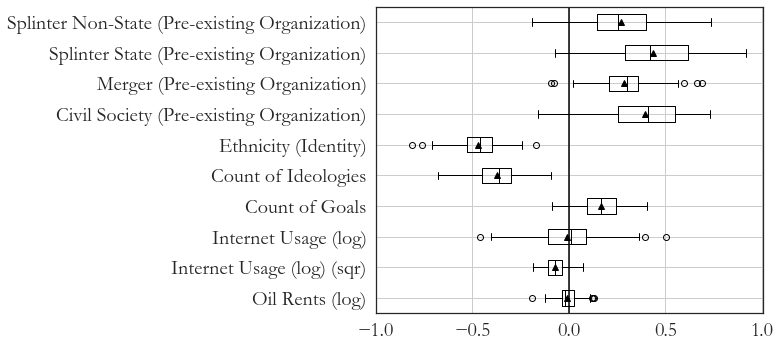

In [41]:
### Bootstrapping beta-coefficients ------
# make empty dataset to store results
betas_all = pd.DataFrame()

# Step 1: initiate bootstrapping
for i in range(1,100):
    model = LogisticRegression(max_iter=1000, 
                               solver='lbfgs')
    
    columns = [ # name of columns in data
     'goal_total',
     'ideo_total',
     'ident_ethnicity',
     'parent_splinter_nonstate',
     'parent_splinter_state',
     'parent_civil_society',
     'parent_merger',
     "active_year_lag",
     "civil_war_dummy",
     'oil_log',
     'internet_use_log',
     "internet_use_log_sqr"]
    
    # draw bootstrapping sample and prepare x/y
    df_all_logit_reps = df_s[df_s.columns & feat_social_networks + feat_natural_resources + \
                             y + con + ["internet_use_log_sqr"]].sample(frac=1,replace=True,random_state=i)
    y_all_logit_reps = df_all_logit_reps['active_year_onset_drop'].copy()
    x_all_logit_reps = df_all_logit_reps.drop('active_year_onset_drop', axis = 1).copy()

    # calculate logit model and merge with predefined dataset
    logit_all_scikit = model.fit(x_all_logit_reps, y_all_logit_reps)
    coef = logit_all_scikit.coef_
    betas = pd.DataFrame(coef,columns=columns)
    betas_all = pd.concat([betas_all, betas])

# Step 2: subset results to only include variables of interest
betas_all_plot = betas_all[['oil_log',
                            "internet_use_log_sqr", 
                            'internet_use_log',
                            'goal_total',
                            'ideo_total',
                            'ident_ethnicity',
                            'parent_civil_society',
                            'parent_merger',
                            'parent_splinter_state',
                            'parent_splinter_nonstate']]

# Step 3: implement boxplot
fig = plt.figure(figsize=(11, 5))
ax = plt.axes()
bp=betas_all_plot.boxplot(vert=False, showmeans=True, medianprops=medianprops, meanprops=meanprops, boxprops=boxprops,
                      return_type='dict')  

# change colors of boxes, whiskers, medians, means
for boxes in bp['boxes']:
    boxes.set_color('black')   
for whis in bp['whiskers']:
    whis.set_color('black')
for median in bp['medians']:
    median.set_color('black')

# change labels
labels = [lab.get_text() for lab in ax.get_yticklabels()]
labels[9] = 'Splinter Non-State (Pre-existing Organization)'
labels[8] = 'Splinter State (Pre-existing Organization)'
labels[7] = 'Merger (Pre-existing Organization)'
labels[6] = 'Civil Society (Pre-existing Organization)'
labels[5] = 'Ethnicity (Identity)'
labels[4] = 'Count of Ideologies'
labels[3] = 'Count of Goals'
labels[2] = 'Internet Usage (log)'
labels[1] = 'Internet Usage (log) (sqr)'
labels[0] = 'Oil Rents (log)'

# set axis
ax.set_yticklabels(labels, fontsize=20)
ax.set_xticks(np.arange(-1, 1.5, 0.5))
ax.tick_params(axis='x', labelsize=20)
plt.axvline(x=0, color='black', linestyle='-')

# Save plot 
fig.savefig(os.path.join(out_paths["box_plot"], f"_box_plot_rebel_strength.png"), dpi=100)

In [42]:
### Check results from bootstrapping  ------
betas_all_plot.head(1)

,oil_log,internet_use_log_sqr,internet_use_log,goal_total,ideo_total,ident_ethnicity,parent_civil_society,parent_merger,parent_splinter_state,parent_splinter_nonstate
0,0.0187,-0.0289,-0.2277,0.2551,-0.2921,-0.4442,0.4413,0.2664,0.6624,0.3617


In [43]:
### Make FacetGrid plot I - preparation -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# transpose data frame
betas_all_plot_melt = pd.melt(betas_all_plot, value_vars=['parent_splinter_nonstate',
                                                          'parent_splinter_state',
                                                          'parent_merger',
                                                          'parent_civil_society',
                                                          'ident_ethnicity',
                                                          'ideo_total',
                                                          'goal_total',
                                                          'internet_use_log',
                                                          "internet_use_log_sqr", 
                                                          'oil_log',])

# dictionary with variable names
dict_names = {1: 'Splinter Non-State (Pre-existing Organization)',
              2: 'Splinter State (Pre-existing Organization)',
              3: 'Merger (Pre-existing Organization)',
              4: 'Civil Society (Pre-existing Organization)',
              5: 'Ethnicity (Identity)',
              6: 'Count of Ideologies',
              7: 'Count of Goals',
              8: 'Internet Usage (log)',
              9: 'Internet Usage (log) (sqr)',
             10: 'Oil Rents (log)'}

# Get mean for the bootstrapping solutions and round
parent_splinter_nonstate_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="parent_splinter_nonstate"].mean())
parent_splinter_nonstate_mean = round(parent_splinter_nonstate_mean[0], 5)
parent_splinter_state_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="parent_splinter_state"].mean())
parent_splinter_state_mean = round(parent_splinter_state_mean[0], 5)
parent_merger_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="parent_merger"].mean())
parent_merger_mean = round(parent_merger_mean[0], 5)
parent_civil_society_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="parent_civil_society"].mean())
parent_civil_society_mean = round(parent_civil_society_mean[0], 5)
ident_ethnicity_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="ident_ethnicity"].mean())
ident_ethnicity_mean = round(ident_ethnicity_mean[0], 5)
ideo_total_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="ideo_total"].mean())
ideo_total_mean = round(ideo_total_mean[0], 5)
goal_total_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="goal_total"].mean())
goal_total_mean = round(goal_total_mean[0], 5)
internet_use_log_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="internet_use_log"].mean())
internet_use_log_mean = round(internet_use_log_mean[0], 5)
internet_use_log_sqr_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="internet_use_log_sqr"].mean())
internet_use_log_sqr_mean = round(internet_use_log_sqr_mean[0], 5)
oil_log_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="oil_log"].mean())
oil_log_mean = round(oil_log_mean[0], 5)

# save means in dictionary
dict_means = {1: parent_splinter_nonstate_mean,
             2: parent_splinter_state_mean,
             3: parent_merger_mean, 
             4: parent_civil_society_mean,
             5: ident_ethnicity_mean,
             6: ideo_total_mean,
             7: goal_total_mean,
             8: internet_use_log_mean,
             9: internet_use_log_sqr_mean,
             10: oil_log_mean}

# get proportion of bootstrapping repetitions which have same sign than mean
#parent_splinter_nonstate_props = (len(betas_all_plot.loc[betas_all_plot["parent_splinter_nonstate"]>0])+1)/100 # positive
parent_splinter_nonstate_props = round(100. * (betas_all_plot["parent_splinter_nonstate"] >= 0).sum() / len(betas_all_plot["parent_splinter_nonstate"].index), 2) # positive
#parent_splinter_state_props = (len(betas_all_plot.loc[betas_all_plot["parent_splinter_state"]>0])+1)/100 # positive
parent_splinter_state_props = round(100. * (betas_all_plot["parent_splinter_state"] >= 0).sum() / len(betas_all_plot["parent_splinter_state"].index), 2) # positive
#parent_merger_props = (len(betas_all_plot.loc[betas_all_plot["parent_merger"]>0])+1)/100 # positive
parent_merger_props = round(100. * (betas_all_plot["parent_merger"] >= 0).sum() / len(betas_all_plot["parent_merger"].index), 2) # positive
#parent_civil_society_props = (len(betas_all_plot.loc[betas_all_plot["parent_civil_society"]>0])+1)/100 # positive
parent_civil_society_props = round(100. * (betas_all_plot["parent_civil_society"] >= 0).sum() / len(betas_all_plot["parent_civil_society"].index), 2) # positive
#ident_ethnicity_props = (len(betas_all_plot.loc[betas_all_plot["ident_ethnicity"]<0])+1)/100 # negative
ident_ethnicity_props = round(100. * (betas_all_plot["ident_ethnicity"] < 0).sum() / len(betas_all_plot["ident_ethnicity"].index), 2) # negative
#ideo_total_props = (len(betas_all_plot.loc[betas_all_plot["ideo_total"]<0])+1)/100 # negative
ideo_total_props = round(100. * (betas_all_plot["ideo_total"] < 0).sum() / len(betas_all_plot["ideo_total"].index), 2) # negative
#goal_total_props = (len(betas_all_plot.loc[betas_all_plot["goal_total"]>0])+1)/100 # positive
goal_total_props = round(100. * (betas_all_plot["goal_total"] >= 0).sum() / len(betas_all_plot["goal_total"].index), 2) # positive
#internet_use_log_props = (len(betas_all_plot.loc[betas_all_plot["internet_use_log"]<0])+1)/100 # negative
internet_use_log_props = round(100. * (betas_all_plot["internet_use_log"] < 0).sum() / len(betas_all_plot["internet_use_log"].index), 2) # negative
#internet_use_log_sqr_props = (len(betas_all_plot.loc[betas_all_plot["internet_use_log_sqr"]<0])+1)/100 # negative
internet_use_log_sqr_props = round(100. * (betas_all_plot["internet_use_log_sqr"] < 0).sum() / len(betas_all_plot["internet_use_log_sqr"].index), 2) # negative
#oil_log_props = (len(betas_all_plot.loc[betas_all_plot["oil_log"]<0])+1)/100 # negative
oil_log_props = round(100. * (betas_all_plot["oil_log"] < 0).sum() / len(betas_all_plot["oil_log"].index), 2) # negative


# save proportions in dictionary
dict_props = {1: parent_splinter_nonstate_props,
             2: parent_splinter_state_props,
             3: parent_merger_props,
             4: parent_civil_society_props,
             5: ident_ethnicity_props,
             6: ideo_total_props,
             7: goal_total_props,
             8: internet_use_log_props,
             9: internet_use_log_sqr_props,
             10: oil_log_props}

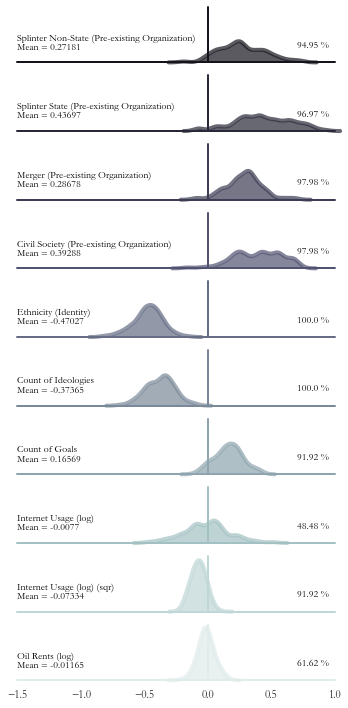

In [44]:
### Make FacetGrid plot II  - make plot -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# get colors
pal = sns.color_palette(palette='bone', n_colors=10)

# specify plot as facet grid
grid = sns.FacetGrid(betas_all_plot_melt, row='variable', hue='variable', aspect=5, height=1, palette=pal, xlim=[-1.5, 1])

# add density plots
grid.map(sns.kdeplot, 'value', clip_on=False,
       shade=True, alpha=0.7, lw=4, bw=.04)

# add line on x=0
grid.map(plt.axvline, x=0,
      lw=2, clip_on=False)

# decrease gap between plots
grid.fig.subplots_adjust(hspace=-0.3)

# add line for y=0
grid.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# add names of variables 
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-1.5, y=2.6, s=dict_names[i+1], fontsize=10,
            color="black")

# add means for bootstrap repetitions    
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-1.5, y=1.5, s=f"Mean = {dict_means[i+1]}", fontsize=10,
            color="black")

# add proportion of repetitions with same sign as mean    
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=0.7, y=1.7, s=f"{dict_props[i+1]} %", fontsize=10,
            color="black")
    
# remove axes, ticks, spines
grid.set_titles("")
grid.set(yticks=[])
grid.despine(bottom=True, left=True)

# save plot
plt.savefig(os.path.join(out_paths["box_plot"], f"_FacetGrid_rebel_strength.png"), dpi=700)

In [45]:
### Check mean values manually -----
print(betas_all_plot["oil_log"].mean())
print(betas_all_plot["internet_use_log_sqr"].mean())
print(betas_all_plot["internet_use_log"].mean())
print(betas_all_plot["goal_total"].mean())
print(betas_all_plot["ideo_total"].mean())
print(betas_all_plot["ident_ethnicity"].mean())
print(betas_all_plot["parent_civil_society"].mean())
print(betas_all_plot["parent_merger"].mean())
print(betas_all_plot["parent_splinter_state"].mean())
print(betas_all_plot["parent_splinter_nonstate"].mean())

-0.011652443368369986
-0.07334345587241842
-0.0077028453177410226
0.16569031571959375
-0.3736498086605027
-0.47027488607207424
0.3928773223345074
0.2867786005177986
0.43697368935453645
0.2718095916887994


In [46]:
### Check proportions manually ------
print(100. * (betas_all_plot["oil_log"] < 0).sum() / len(betas_all_plot["oil_log"].index))
print(100. * (betas_all_plot["oil_log"] >= 0).sum() / len(betas_all_plot["oil_log"].index))
print(100. * (betas_all_plot["internet_use_log_sqr"] < 0).sum() / len(betas_all_plot["internet_use_log_sqr"].index))
print(100. * (betas_all_plot["internet_use_log_sqr"] >= 0).sum() / len(betas_all_plot["internet_use_log_sqr"].index))
print(100. * (betas_all_plot["internet_use_log"] < 0).sum() / len(betas_all_plot["internet_use_log"].index))
print(100. * (betas_all_plot["internet_use_log"] >= 0).sum() / len(betas_all_plot["internet_use_log"].index))
print(100. * (betas_all_plot["goal_total"] < 0).sum() / len(betas_all_plot["goal_total"].index))
print(100. * (betas_all_plot["goal_total"] >= 0).sum() / len(betas_all_plot["goal_total"].index))
print(100. * (betas_all_plot["ideo_total"] < 0).sum() / len(betas_all_plot["ideo_total"].index))
print(100. * (betas_all_plot["ideo_total"] >= 0).sum() / len(betas_all_plot["ideo_total"].index))
print(100. * (betas_all_plot["ident_ethnicity"] < 0).sum() / len(betas_all_plot["ident_ethnicity"].index))
print(100. * (betas_all_plot["ident_ethnicity"] >= 0).sum() / len(betas_all_plot["ident_ethnicity"].index))
print(100. * (betas_all_plot["parent_civil_society"] < 0).sum() / len(betas_all_plot["parent_civil_society"].index))
print(100. * (betas_all_plot["parent_civil_society"] >= 0).sum() / len(betas_all_plot["parent_civil_society"].index))
print(100. * (betas_all_plot["parent_merger"] < 0).sum() / len(betas_all_plot["parent_merger"].index))
print(100. * (betas_all_plot["parent_merger"] >= 0).sum() / len(betas_all_plot["parent_merger"].index))
print(100. * (betas_all_plot["parent_splinter_state"] < 0).sum() / len(betas_all_plot["parent_splinter_state"].index))
print(100. * (betas_all_plot["parent_splinter_state"] >= 0).sum() / len(betas_all_plot["parent_splinter_state"].index))
print(100. * (betas_all_plot["parent_splinter_nonstate"] < 0).sum() / len(betas_all_plot["parent_splinter_nonstate"].index))
print(100. * (betas_all_plot["parent_splinter_nonstate"] >= 0).sum() / len(betas_all_plot["parent_splinter_nonstate"].index))

61.61616161616162
38.38383838383838
91.91919191919192
8.080808080808081
48.484848484848484
51.515151515151516
8.080808080808081
91.91919191919192
100.0
0.0
100.0
0.0
2.0202020202020203
97.97979797979798
2.0202020202020203
97.97979797979798
3.0303030303030303
96.96969696969697
5.05050505050505
94.94949494949495


### State Capacity Model
This section implements the state capacity model which includes the following variables: quality of government, military expenditure index, military personnel index and the combined polity score. In order to validate the inverted u-shaped association between the polity score and the outcome, the main term is complemented by a squared term. 

In [47]:
### Prepare data for statsmodels -----------------
df_s["polity2_sqr"] = df_s["polity2"] * df_s["polity2"] # define quadratic term
df_state_capacity_logit = df_s[df_s.columns & feat_state_capacity + y + con + ["polity2_sqr"]].copy()

In [48]:
### Get data for statsmodels ----
y_state_capacity_logit = df_state_capacity_logit['active_year_onset_drop'].copy()
x_state_capacity_logit = df_state_capacity_logit.drop('active_year_onset_drop', axis = 1).copy()
#x_state_capacity_logit = sm.add_constant(x_state_capacity_logit.values) # add constant for statsmodels <-- to stop warning (but variable labels disappear)
x_state_capacity_logit = sm.add_constant(x_state_capacity_logit)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [49]:
### Implement logit model with statsmodels ------
logit_state_capacity = sm.Logit(y_state_capacity_logit, x_state_capacity_logit)
logit_state_capacity = logit_state_capacity.fit(maxiter=1000,
                                                method='lbfgs', 
                                                cov_type='HC1')
logit_state_capacity.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:              Logit                  Pseudo R-squared: 0.179     
Dependent Variable: active_year_onset_drop AIC:              1317.6837 
Date:               2021-05-19 09:07       BIC:              1359.4174 
No. Observations:   1362                   Log-Likelihood:   -650.84   
Df Model:           7                      LL-Null:          -792.66   
Df Residuals:       1354                   LLR p-value:      1.8777e-57
Converged:          1.0000                 Scale:            1.0000    
No. Iterations:     56.0000                                            
-----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------
const                0.3633   0.2502    1.4518 0.1466  -0.1272   0.8537
gov_qual            -2.4929   0.5819   -4.2841 0.0000  -3.6334  -1.3524
milexp_in            0.2550   0.1209    2.1097 0.0349   0.0181   0.4919
milper_in           -0.1517   0.1458   -1.0407 0.2980  -0.4375   0.1340
polity2              0.0191   0.0155    1.2316 0.2181  -0.0113   0.0495
active_year_lag    -12.7267   0.1076 -118.3109 0.0000 -12.9376 -12.5159
civil_war_dummy      6.0303   0.2104   28.6639 0.0000   5.6180   6.4427
polity2_sqr         -0.0109   0.0030   -3.6092 0.0003  -0.0169  -0.0050
=======================================================================

"""

In [50]:
### Prepare data for scikit learn implementation -----
df_state_capacity_logit = df_s[df_s.columns & feat_state_capacity + y + con + ["polity2_sqr"]].copy()

In [51]:
### Get data for scikit learn implementation -----
y_state_capacity_logit = df_state_capacity_logit['active_year_onset_drop'].copy()
x_state_capacity_logit = df_state_capacity_logit.drop('active_year_onset_drop', axis = 1).copy()

In [52]:
### Implement logit model with scikit learn ----
model = LogisticRegression(max_iter=1000, 
                           solver='lbfgs')
logit_scikit_state_capacity = model.fit(x_state_capacity_logit, y_state_capacity_logit)

# show coefficients
print(logit_scikit_state_capacity.intercept_)
logit_scikit_state_capacity.coef_

[0.20033901]


array([[-1.78089122,  0.21096216, -0.18568943,  0.00741551, -3.37526922,
         3.01525291, -0.01169101]])

In [53]:
### Check order of x-variables ------
for i in x_state_capacity_logit.columns:
    print(i)

gov_qual
milexp_in
milper_in
polity2
active_year_lag
civil_war_dummy
polity2_sqr


In [54]:
### Make regression table with scikit learn and z statistics -------
pd.options.display.float_format = '{:.4f}'.format

# get regression table and insert variable names
reg_tab_state_capacity = logit_pvalue(logit_scikit_state_capacity, x_state_capacity_logit)
reg_tab_state_capacity
reg_tab_state_capacity.insert(0, "Var", ['Intercept', 'gov_qual',
     'milexp_in',
     'milper_in',
     'polity2',
     "active_year_lag",
     "civil_war_dummy",
     "polity2_sqr"])

# sort coefficients
reg_tab_state_capacity = reg_tab_state_capacity.reindex([1, 4, 7, 2, 3, 5, 6, 0])
reg_tab_state_capacity = reg_tab_state_capacity.reset_index(drop=True)

# add fancy names from dictionary 
for row in reg_tab_state_capacity.iterrows():
    feat=row[1][0]
    feat_long=dict_feat_names[feat]
    reg_tab_state_capacity.loc[reg_tab_state_capacity['Var'] == feat, 'Variable'] = feat_long
    
# save table
reg_tab_state_capacity = reg_tab_state_capacity.drop(['Var'], axis=1)
reg_tab_state_capacity = reg_tab_state_capacity[['Variable', "Coefficients", "Standard Errors", "t Values", "p Values"]]
reg_tab_state_capacity.to_latex(os.path.join(out_paths["reg_tab"], f"_reg_tab_state_capacity.tex"), index=False)
reg_tab_state_capacity

,Variable,Coefficients,Standard Errors,t Values,p Values
0,Quality of Government,-1.7809,0.5538,-3.2159,0.0013
1,Combined Polity Score,0.0074,0.0145,0.5122,0.6085
2,Combined Polity Score (sqr),-0.0117,0.0029,-4.0540,0.0001
3,Military Expenditure Index,0.2110,0.1217,1.7336,0.0830
4,Military Personnel Index,-0.1857,0.1446,-1.2845,0.1990
5,Transition to Civil Conflict (lag),-3.3753,0.5568,-6.0617,0.0000
6,Transition to Civil War,3.0153,0.6191,4.8705,0.0000
7,Intercept,0.2003,0.2501,0.8010,0.4231


In [55]:
### Check order of x-variables ------
for i in x_state_capacity_logit.columns:
    print(i)

gov_qual
milexp_in
milper_in
polity2
active_year_lag
civil_war_dummy
polity2_sqr


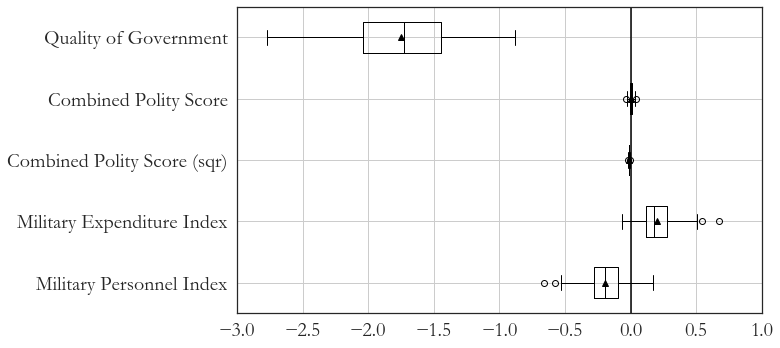

In [56]:
### Boostrapping beta-coeffiecient ------
# make empty dataset to store results
betas_all = pd.DataFrame()

# Step 1: initiate bootstrapping
for i in range(1,100):
    model = LogisticRegression(max_iter=1000, 
                               solver='lbfgs')
    
    columns = ['gov_qual',  # name of columns in data
               'milexp_in',
               'milper_in',
               'polity2', 
               'active_year_lag',
               "civil_war_dummy", 
               "polity2_sqr"]
    
    # draw bootstrapping sample and prepare x/y
    df_all_logit_reps = df_s[df_s.columns & feat_state_capacity + y + con + ["polity2_sqr"]].sample(frac=1,replace=True,random_state=i)
    y_all_logit_reps = df_all_logit_reps['active_year_onset_drop'].copy()
    x_all_logit_reps = df_all_logit_reps.drop('active_year_onset_drop', axis = 1).copy()

    # calculate logit model and merge with predefined dataset
    logit_all_scikit = model.fit(x_all_logit_reps, y_all_logit_reps)
    coef = logit_all_scikit.coef_
    betas = pd.DataFrame(coef,columns=columns)
    betas_all = pd.concat([betas_all, betas])

# Step 2: subset results to only include variables of interest
betas_all_plot = betas_all[['milper_in', 
                            'milexp_in', 
                            "polity2_sqr", 
                            'polity2', 
                            'gov_qual']].copy()

# Step 3: implement boxplot
fig = plt.figure(figsize=(11, 5))
ax = plt.axes()
bp=betas_all_plot.boxplot(vert=False, showmeans=True, medianprops=medianprops, meanprops=meanprops, boxprops=boxprops,
                      return_type='dict')  

# change colors of boxes, whiskers, medians, means
for box in bp['boxes']:
    box.set_color('black')   
for whis in bp['whiskers']:
    whis.set_color('black')
for median in bp['medians']:
    median.set_color('black')

# change labels 
labels = [lab.get_text() for lab in ax.get_yticklabels()]
labels[4] = 'Quality of Government'
labels[1] = 'Military Expenditure Index'
labels[0] = 'Military Personnel Index'
labels[3] = 'Combined Polity Score'
labels[2] = 'Combined Polity Score (sqr)'

ax.set_yticklabels(labels, fontsize=20)
ax.set_xticks(np.arange(-3, 1.5, 0.5))
ax.tick_params(axis='x', labelsize=20)
plt.axvline(x=0, color='black', linestyle='-')

# Save plot 
fig.savefig(os.path.join(out_paths["box_plot"], f"_box_plot_state_capacity.png"), dpi=100)

In [57]:
### Check results from bootstrapping  ------
betas_all_plot.head(1)

,milper_in,milexp_in,polity2_sqr,polity2,gov_qual
0,-0.4167,0.2531,-0.0109,-0.0004,-1.5453


In [58]:
### Make FacetGrid plot I - preparation -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# transpose data frame
betas_all_plot_melt = pd.melt(betas_all_plot, value_vars=['gov_qual', 'polity2', "polity2_sqr", 'milexp_in', 'milper_in', ])

# dictionary with variable names
dict_names = {1: 'Quality of Government',
              2: 'Combined Polity Score',
              3: 'Combined Polity Score (sqr)',
              4: 'Military Expenditure Index',
              5: 'Military Personnel Index'}

# Get mean for the bootstrapping solutions and round
gov_qual_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="gov_qual"].mean())
gov_qual_mean = round(gov_qual_mean[0], 5)
polity_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="polity2"].mean())
polity_mean = round(polity_mean[0], 5)
polity2_sqr_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="polity2_sqr"].mean())
polity2_sqr_mean = round(polity2_sqr_mean[0], 5)
milexp_in_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="milexp_in"].mean())
milexp_in_mean = round(milexp_in_mean[0], 5)
milper_in_mean = list(betas_all_plot_melt.loc[betas_all_plot_melt["variable"]=="milper_in"].mean())
milper_in_mean = round(milper_in_mean[0], 5)

# save means in dictionary
dict_means = {1: gov_qual_mean,
             2: polity_mean,
             3: polity2_sqr_mean,
             4: milexp_in_mean,
             5: milper_in_mean}

# get proportion of bootstrapping repetitions which have same sign than mean
#gov_qual_props = (len(betas_all_plot.loc[betas_all_plot["gov_qual"]<0])+1)/100 # negative
gov_qual_props = round(100. * (betas_all_plot["gov_qual"] < 0).sum() / len(betas_all_plot["gov_qual"].index), 2) # negative
#polity_props = (len(betas_all_plot.loc[betas_all_plot["polity2"]>0])+1)/100 # positive
polity_props = round(100. * (betas_all_plot["polity2"] >= 0).sum() / len(betas_all_plot["polity2"].index), 2) # positive
#polity2_sqr_props = (len(betas_all_plot.loc[betas_all_plot["polity2_sqr"]<0])+1)/100 # negative
polity2_sqr_props = round(100. * (betas_all_plot["polity2_sqr"] < 0).sum() / len(betas_all_plot["polity2_sqr"].index), 2) # negative
#milexp_in_props = (len(betas_all_plot.loc[betas_all_plot["milexp_in"]>0])+1)/100 # positive
milexp_in_props = round(100. * (betas_all_plot["milexp_in"] >= 0).sum() / len(betas_all_plot["milexp_in"].index), 2) # positive
#milper_in_props = (len(betas_all_plot.loc[betas_all_plot["milper_in"]<0])+1)/100 # negative
milper_in_props = round(100. * (betas_all_plot["milper_in"] < 0).sum() / len(betas_all_plot["milper_in"].index), 2) # negative


# save proportions in dictionary
dict_props = {1: gov_qual_props,
             2: polity_props,
             3: polity2_sqr_props,
             4: milexp_in_props,
             5: milper_in_props}

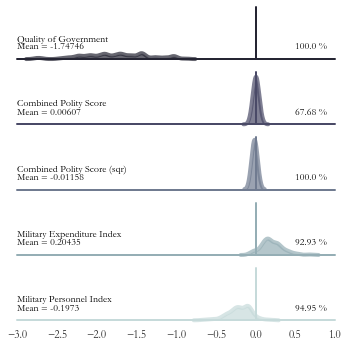

In [59]:
### Make FacetGrid plot II  - make plot -------
# Instructions are obtained from: https://www.python-graph-gallery.com/ridgeline-graph-seaborn

# get colors
pal = sns.color_palette(palette='bone', n_colors=5)

# specify plot as facet grid
grid = sns.FacetGrid(betas_all_plot_melt, row='variable', hue='variable', aspect=5, height=1, palette=pal, xlim=[-3, 1])
  
# add density plots
grid.map(sns.kdeplot, 'value', clip_on=False,
       shade=True, alpha=0.7, lw=4, bw=.04)

# add line on x=0
grid.map(plt.axvline, x=0,
      lw=2, clip_on=False)

# decrease gap between plots
grid.fig.subplots_adjust(hspace=-10)

# add line for y=0
grid.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# add names of variables 
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-3, y=3.7, s=dict_names[i+1], fontsize=10,
            color="black")
    
# add means for bootstrap repetitions        
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=-3, y=2, s=f"Mean = {dict_means[i+1]}", fontsize=10,
            color="black")

# add proportion of repetitions with same sign as mean    
for i, axis in enumerate(grid.axes.flat):
    axis.text(x=0.5, y=2, s=f"{dict_props[i+1]} %", fontsize=10,
            color="black")
    
# remove axes, ticks, spines
grid.set_titles("")
grid.set(yticks=[])
grid.despine(bottom=True, left=True)

# save plot
plt.savefig(os.path.join(out_paths["box_plot"], f"_FacetGrid_state_capacity.png"), dpi=700)

In [60]:
### Check mean values manually -----
print(betas_all_plot["milper_in"].mean())
print(betas_all_plot["milexp_in"].mean())
print(betas_all_plot["polity2_sqr"].mean())
print(betas_all_plot["polity2"].mean())
print(betas_all_plot["gov_qual"].mean())

-0.19730136955706715
0.2043542868380007
-0.011582357730151477
0.00606601737954842
-1.7474604753787222


In [61]:
### Check proportions manually ------
print(100. * (betas_all_plot["milper_in"] < 0).sum() / len(betas_all_plot["milper_in"].index))
print(100. * (betas_all_plot["milper_in"] >= 0).sum() / len(betas_all_plot["milper_in"].index))
print(100. * (betas_all_plot["milexp_in"] < 0).sum() / len(betas_all_plot["milexp_in"].index))
print(100. * (betas_all_plot["milexp_in"] >= 0).sum() / len(betas_all_plot["milexp_in"].index))
print(100. * (betas_all_plot["polity2_sqr"] < 0).sum() / len(betas_all_plot["polity2_sqr"].index))
print(100. * (betas_all_plot["polity2_sqr"] >= 0).sum() / len(betas_all_plot["polity2_sqr"].index))
print(100. * (betas_all_plot["polity2"] < 0).sum() / len(betas_all_plot["polity2"].index))
print(100. * (betas_all_plot["polity2"] >= 0).sum() / len(betas_all_plot["polity2"].index))
print(100. * (betas_all_plot["gov_qual"] < 0).sum() / len(betas_all_plot["gov_qual"].index))
print(100. * (betas_all_plot["gov_qual"] >= 0).sum() / len(betas_all_plot["gov_qual"].index))

94.94949494949495
5.05050505050505
7.070707070707071
92.92929292929293
100.0
0.0
32.323232323232325
67.67676767676768
100.0
0.0


### Baseline Model
The baseline model is implemented in this section and includes the following variables a lagged dependent variable and the civil war dummy. 

In [62]:
### Prepare data for statsmodels  -----
df_baseline = df_s[df_s.columns & y + con ].copy()

In [63]:
### Get data for statsmodels  -----
y_base_logit = df_baseline['active_year_onset_drop'].copy()
x_base_logit = df_baseline.drop('active_year_onset_drop', axis = 1).copy()
#x_base_logit = sm.add_constant(x_base.values) # add constant for statsmodels <-- to stop warning (but variable labels disappear)
x_base_logit = sm.add_constant(x_base_logit)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [64]:
### Implement logit model with statsmodels ------
logit_base = sm.Logit(y_base_logit, x_base_logit)
logit_base = logit_base.fit(maxiter=1000,
                            method='lbfgs', 
                            cov_type='HC1')
logit_base.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:              Logit                  Pseudo R-squared: 0.141     
Dependent Variable: active_year_onset_drop AIC:              1367.4921 
Date:               2021-05-19 09:07       BIC:              1383.1422 
No. Observations:   1362                   Log-Likelihood:   -680.75   
Df Model:           2                      LL-Null:          -792.66   
Df Residuals:       1359                   LLR p-value:      2.4855e-49
Converged:          1.0000                 Scale:            1.0000    
No. Iterations:     19.0000                                            
-----------------------------------------------------------------------
                    Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------
const               -0.8644   0.0654  -13.2105 0.0000  -0.9926  -0.7361
active_year_lag    -11.2230   0.0953 -117.7213 0.0000 -11.4098 -11.0361
civil_war_dummy     13.3236   0.1836   72.5859 0.0000  12.9639  13.6834
=======================================================================

"""

In [65]:
### Prepare data for scikit learn implementation -----
df_baseline = df_s[df_s.columns & y + con ].copy()

In [66]:
### Get data for scikit learn implementation -----
y_base_logit = df_baseline['active_year_onset_drop'].copy()
x_base_logit = df_baseline.drop('active_year_onset_drop', axis = 1).copy()

In [67]:
### Implement logit model with scikit learn ----
model = LogisticRegression(max_iter=1000, 
                           solver='lbfgs')
logit_scikit_base = model.fit(x_base_logit, y_base_logit)

# Show coefficients
print(logit_scikit_base.intercept_)
logit_scikit_base.coef_

[-0.8648908]


array([[-3.27151905,  3.14750315]])

In [68]:
### Check order of x-variables ------
for i in x_base_logit.columns:
    print(i)

active_year_lag
civil_war_dummy


In [69]:
### Make regression table with scikit learn and z statistics -------
pd.options.display.float_format = '{:.4f}'.format

# get regression table and insert variable names
reg_tab_base = logit_pvalue(logit_scikit_base, x_base_logit)
reg_tab_base
reg_tab_base.insert(0, "Var", ['Intercept',"active_year_lag", "civil_war_dummy"])

# sort coefficients
reg_tab_base = reg_tab_base.reindex([1,2,0])
reg_tab_base = reg_tab_base.reset_index(drop=True)

# add fancy names from dictionary
for row in reg_tab_base.iterrows():
    feat=row[1][0]
    feat_long=dict_feat_names[feat]
    reg_tab_base.loc[reg_tab_base['Var'] == feat, 'Variable'] = feat_long
    
# save table
reg_tab_base = reg_tab_base.drop(['Var'], axis=1)
reg_tab_base = reg_tab_base[['Variable', "Coefficients", "Standard Errors", "t Values", "p Values"]]
reg_tab_base.to_latex(os.path.join(out_paths["reg_tab"], f"_reg_tab_baseline.tex"), index=False)
reg_tab_base

,Variable,Coefficients,Standard Errors,t Values,p Values
0,Transition to Civil Conflict (lag),-3.2715,0.5611,-5.8306,0.0000
1,Transition to Civil War,3.1475,0.5953,5.2871,0.0000
2,Intercept,-0.8649,0.0654,-13.2171,0.0000


### Prediction with Cross-validation
Similar to the random forest, the logit models are cross-validated in the subsequent sections. An evaluation table is stored locally.

In [70]:
### Write function to implement k-fold cv -----
# Implemented based on https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
# and https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

def k_fold_cv(df, model,
             x,
             y,
             suffix,
             n=10
             ):
    
    df[f"predictions_{suffix}"] = np.nan # make empty data column to store predictions
    col_list = []
    
    for i in range(1,n+1): # is repeated n-times
        kf = KFold(n_splits=10, shuffle=True, random_state=i) # define cross validation partitions, 10 splits
        df[f"predictions_{suffix}_cv_{i}"] = cross_val_predict(model, x, y, cv=kf, method='predict_proba')[:, 1] # predict probabilities
        # and extract predictions for y=1
        col_list.append(f"predictions_{suffix}_cv_{i}")
        print(f"Finished cv {i}")
    
    # aggregate to final prediction by taking the mean
    df[f"predictions_{suffix}"] = df[col_list].mean(axis=1)
    
    return 

In [71]:
### Make k-fold cv ------
k_fold_cv(df_rebel_visibility_logit, logit_scikit_rebel_visi, x_rebel_visi_logit, y_rebel_visi_logit, suffix="rebel_visibility")
df_rebel_visibility_logit.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


foundloc_cat_cat  age_formation  forest_cov  \
ccode_wb dyad_new_id year                                                
IRN      406         1989            2.0000        44.0000     35.2896   
                     1990            2.0000        45.0000      5.5724   
                     1991            2.0000        46.0000      5.5877   

                            rural  terrain  active_year_lag  \
ccode_wb dyad_new_id year                                     
IRN      406         1989 44.2060 244.5000           0.0000   
                     1990 43.6700 244.5000           0.0000   
                     1991 43.1350 244.5000           1.0000   

                           active_year_onset_drop  civil_war_dummy  \
ccode_wb dyad_new_id year                                            
IRN      406         1989                       0                0   
                     1990                       1                0   
                     1991                       0                0   

                           age_formation_sqr  predictions_rebel_visibility  \
ccode_wb dyad_new_id year                                                    
IRN      406         1989          1936.0000                        0.1248   
                     1990          2025.0000                        0.1398   
                     1991          2116.0000                        0.0056   

                           predictions_rebel_visibility_cv_1  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1229   
                     1990                             0.1374   
                     1991                             0.0055   

                           predictions_rebel_visibility_cv_2  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1275   
                     1990                             0.1272   
                     1991                             0.0050   

                           predictions_rebel_visibility_cv_3  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1201   
                     1990                             0.1426   
                     1991                             0.0050   

                           predictions_rebel_visibility_cv_4  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1198   
                     1990                             0.1394   
                     1991                             0.0058   

                           predictions_rebel_visibility_cv_5  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1180   
                     1990                             0.1558   
                     1991                             0.0065   

                           predictions_rebel_visibility_cv_6  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1289   
                     1990                             0.1411   
                     1991                             0.0056   

                           predictions_rebel_visibility_cv_7  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1295   
                     1990                             0.1435   
                     1991                             0.0059   

                           predictions_rebel_visibility_cv_8  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                             0.1282   
                     1990                             0.1426   
                     1991                             0.0055   

                           pre

In [72]:
### Write function to get evaluations -------
# Implemented based on https://scikit-learn.org/stable/modules/model_evaluation.html

def evaluations(df, 
                predictions, 
                actual, 
                model_name):
    # make empty data frame to store results
    table = pd.DataFrame(columns=['Model', 'Brier', 'AUROC', 'AUPR'])

    # calculate brier
    brier = brier_score_loss(df[f"{actual}"], df[f"{predictions}"])
    print('Brier:', round(np.mean(brier), 4))
    
    # get false_postive, true_positive, precision, recall
    false_positive, true_positive, threshold = metrics.roc_curve(df[f"{actual}"], df[f"{predictions}"])
    precision, recall, threshold = metrics.precision_recall_curve(df[f"{actual}"], df[f"{predictions}"])
    
    # calculate auroc
    auroc = metrics.auc(false_positive, true_positive)
    print('AUROC:', round(np.mean(auroc), 4))
    
    # calculate aupr
    aupr = metrics.auc(recall, precision)
    print('AUPR:', round(np.mean(aupr), 4))
    
    # generate table
    table = table.append({'Model': model_name, 'Brier': brier, 'AUROC': auroc, 'AUPR': aupr}, ignore_index=True)
    
    return false_positive, true_positive, auroc, precision, recall, aupr, table

In [73]:
### Get evaluation scores ---------
fpr_rebel_visi, tpr_rebel_visi, roc_auc_rebel_visi, precision_rebel_visi, recall_rebel_visi, pr_auc_rebel_visi, table_rebel_visi = evaluations(
                                                                                                    df_rebel_visibility_logit, "predictions_rebel_visibility", 
                                                                                                    "active_year_onset_drop", "Rebel Visibility Model")
table_rebel_visi

Brier: 0.1544
AUROC: 0.7787
AUPR: 0.6012


,Model,Brier,AUROC,AUPR
0,Rebel Visibility Model,0.1544,0.7787,0.6012


In [74]:
### Get negative log likelihood -----
log_loss(df_rebel_visibility_logit["active_year_onset_drop"], 
         df_rebel_visibility_logit["predictions_rebel_visibility"])

0.4649653485060455

In [75]:
### Make k-fold cv ------
k_fold_cv(df_rebel_strength_logit, logit_scikit_rebel_strength, x_rebel_strength_logit, y_rebel_strength_logit, suffix="rebel_strength")
df_rebel_strength_logit.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


goal_total  ideo_total  ident_ethnicity  \
ccode_wb dyad_new_id year                                            
IRN      406         1989      1.0000      1.0000           1.0000   
                     1990      1.0000      1.0000           1.0000   
                     1991      1.0000      1.0000           1.0000   

                           parent_splinter_nonstate  parent_splinter_state  \
ccode_wb dyad_new_id year                                                    
IRN      406         1989                    0.0000                 0.0000   
                     1990                    0.0000                 0.0000   
                     1991                    0.0000                 0.0000   

                           parent_civil_society  parent_merger  \
ccode_wb dyad_new_id year                                        
IRN      406         1989                1.0000         0.0000   
                     1990                1.0000         0.0000   
                     1991                1.0000         0.0000   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989           0.0000                       0   
                     1990           0.0000                       1   
                     1991           1.0000                       0   

                           civil_war_dummy  ...  \
ccode_wb dyad_new_id year                   ...   
IRN      406         1989                0  ...   
                     1990                0  ...   
                     1991                0  ...   

                           predictions_rebel_strength_cv_1  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2394   
                     1990                           0.2530   
                     1991                           0.0134   

                           predictions_rebel_strength_cv_2  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2667   
                     1990                           0.2819   
                     1991                           0.0126   

                           predictions_rebel_strength_cv_3  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2306   
                     1990                           0.2579   
                     1991                           0.0146   

                           predictions_rebel_strength_cv_4  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2375   
                     1990                           0.2743   
                     1991                           0.0136   

                           predictions_rebel_strength_cv_5  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2289   
                     1990                           0.2886   
                     1991                           0.0143   

                           predictions_rebel_strength_cv_6  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2387   
                     1990                           0.2591   
                     1991                           0.0128   

                           predictions_rebel_strength_cv_7  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.2482   
                     1990                           0.2667   
                     1991                           0.0133   

                           predictions_rebel_strength_cv_8  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                     

In [76]:
### Get evaluation scores ---------
fpr_rebel_strength, tpr_rebel_strength, roc_auc_rebel_strength, precision_rebel_strength, recall_rebel_strength, pr_auc_rebel_strength, table_rebel_strength = evaluations(
                                                                                                    df_rebel_strength_logit, "predictions_rebel_strength", 
                                                                                                    "active_year_onset_drop", "Rebel Strength Model")
table_rebel_strength

Brier: 0.1638
AUROC: 0.7383
AUPR: 0.5338


,Model,Brier,AUROC,AUPR
0,Rebel Strength Model,0.1638,0.7383,0.5338


In [77]:
### Get log likelihood -----
log_loss(df_rebel_strength_logit["active_year_onset_drop"], 
         df_rebel_strength_logit["predictions_rebel_strength"])

0.48599189814421095

In [78]:
### Make k-fold cv ------
k_fold_cv(df_state_capacity_logit, logit_scikit_state_capacity, x_state_capacity_logit, y_state_capacity_logit, suffix="state_capacity")
df_state_capacity_logit.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


gov_qual  milexp_in  milper_in  polity2  \
ccode_wb dyad_new_id year                                            
IRN      406         1989    0.3056     1.8140     1.2078  -6.0000   
                     1990    0.3056     1.8400     0.5200  -6.0000   
                     1991    0.3704     1.5200     0.5200  -6.0000   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989           0.0000                       0   
                     1990           0.0000                       1   
                     1991           1.0000                       0   

                           civil_war_dummy  polity2_sqr  \
ccode_wb dyad_new_id year                                 
IRN      406         1989                0      36.0000   
                     1990                0      36.0000   
                     1991                0      36.0000   

                           predictions_state_capacity  \
ccode_wb dyad_new_id year                               
IRN      406         1989                      0.3446   
                     1990                      0.3679   
                     1991                      0.0186   

                           predictions_state_capacity_cv_1  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3509   
                     1990                           0.3697   
                     1991                           0.0195   

                           predictions_state_capacity_cv_2  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3556   
                     1990                           0.3659   
                     1991                           0.0173   

                           predictions_state_capacity_cv_3  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3426   
                     1990                           0.3748   
                     1991                           0.0210   

                           predictions_state_capacity_cv_4  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3411   
                     1990                           0.3740   
                     1991                           0.0170   

                           predictions_state_capacity_cv_5  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3427   
                     1990                           0.3751   
                     1991                           0.0184   

                           predictions_state_capacity_cv_6  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3384   
                     1990                           0.3536   
                     1991                           0.0176   

                           predictions_state_capacity_cv_7  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3377   
                     1990                           0.3658   
                     1991                           0.0194   

                           predictions_state_capacity_cv_8  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3546   
                     1990                           0.3547   
                     1991                           0.0194   

                           predictions_state_capacity_cv_9  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                           0.3456   
                     1990                           0.3763   
       

In [79]:
### Get evaluation scores ---------
fpr_state_cap, tpr_state_cap, roc_auc_state_cap, precision_state_cap, recall_state_cap, pr_auc_state_cap, table_state_cap = evaluations(
                                                                                                    df_state_capacity_logit, "predictions_state_capacity", 
                                                                                                    "active_year_onset_drop", "State Capacity Model")
table_state_cap

Brier: 0.1649
AUROC: 0.7288
AUPR: 0.5257


,Model,Brier,AUROC,AUPR
0,State Capacity Model,0.1649,0.7288,0.5257


In [80]:
### Get log likelihood -----
log_loss(df_state_capacity_logit["active_year_onset_drop"], 
         df_state_capacity_logit["predictions_state_capacity"])

0.4882526656097319

In [81]:
### Make k-fold cv ------
k_fold_cv(df_baseline, logit_scikit_base, x_base_logit, y_base_logit, suffix="base")
df_baseline.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989           0.0000                       0   
                     1990           0.0000                       1   
                     1991           1.0000                       0   

                           civil_war_dummy  predictions_base  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                0            0.2985   
                     1990                0            0.2983   
                     1991                0            0.0172   

                           predictions_base_cv_1  predictions_base_cv_2  \
ccode_wb dyad_new_id year                                                 
IRN      406         1989                 0.3005                 0.2983   
                     1990                 0.3005                 0.2972   
                     1991                 0.0169                 0.0168   

                           predictions_base_cv_3  predictions_base_cv_4  \
ccode_wb dyad_new_id year                                                 
IRN      406         1989                 0.2981                 0.2959   
                     1990                 0.2935                 0.3051   
                     1991                 0.0181                 0.0172   

                           predictions_base_cv_5  predictions_base_cv_6  \
ccode_wb dyad_new_id year                                                 
IRN      406         1989                 0.2950                 0.3007   
                     1990                 0.3022                 0.2940   
                     1991                 0.0173                 0.0171   

                           predictions_base_cv_7  predictions_base_cv_8  \
ccode_wb dyad_new_id year                                                 
IRN      406         1989                 0.2971                 0.3014   
                     1990                 0.2940                 0.3024   
                     1991                 0.0173                 0.0168   

                           predictions_base_cv_9  predictions_base_cv_10  
ccode_wb dyad_new_id year                                                 
IRN      406         1989                 0.2997                  0.2987  
                     1990                 0.2997                  0.2946  
                     1991                 0.0172                  0.0170

In [82]:
### Get evaluation scores ---------
fpr_base, tpr_base, roc_auc_base, precision_base, recall_base, pr_auc_base, table_base = evaluations(
                                                                                            df_baseline, "predictions_base", 
                                                                                            "active_year_onset_drop", "Baseline Model")
table_base

Brier: 0.172
AUROC: 0.5307
AUPR: 0.3507


,Model,Brier,AUROC,AUPR
0,Baseline Model,0.1720,0.5307,0.3507


In [83]:
### Get log likelihood -----
log_loss(df_baseline["active_year_onset_drop"], 
         df_baseline["predictions_base"])

0.5057081904699887

In [84]:
### Table showing evaluation scores for all models  ------
pd.options.display.float_format = '{:.5f}'.format
tab_eval_complete = pd.concat([table_state_cap, table_rebel_visi]) # merge separate models
tab_eval_complete = pd.concat([tab_eval_complete, table_rebel_strength])
tab_eval_complete = pd.concat([tab_eval_complete, table_base])
tab_eval_complete = tab_eval_complete.round(decimals=5)

# Save table
tab_eval_complete.to_latex(os.path.join(out_paths["reg_tab"], f"_eval_table_all.tex"), index=False)
tab_eval_complete

,Model,Brier,AUROC,AUPR
0,State Capacity Model,0.16491,0.72885,0.52565
0,Rebel Visibility Model,0.15435,0.77868,0.60118
0,Rebel Strength Model,0.16382,0.73832,0.53381
0,Baseline Model,0.17204,0.53067,0.35070


### Model with all Features
This section implements a model with all features.

In [85]:
### Prepare data for statsmodels  -----------------
df_s["age_formation_sqr"] = df_s["age_formation"] * (df_s["age_formation"]) # define squared term

# there was a convergence issue in statsmodels which is why I rescaled the quadratic term
# this is not that relevant since statsmodels are only used as a robustness check
# the analysis is focused on the scikit learn library which did not encounter this problem
df_s["age_formation_sqr_re"] = df_s["age_formation_sqr"]  / 100

df_s["internet_use_log_sqr"] = df_s["internet_use_log"] * df_s["internet_use_log"] # define quadratic term

df_s["polity2_sqr"] = df_s["polity2"] * df_s["polity2"] # define quadratic term

df_all = df_s[df_s.columns & feat_rebel_visibility + y + con + ["age_formation_sqr_re"] + feat_social_networks + feat_natural_resources \
             + ["internet_use_log_sqr"] + feat_state_capacity + ["polity2_sqr"]].copy()

In [86]:
### Get data for statsmodels  -----
y_all_logit = df_all['active_year_onset_drop'].copy()
x_all_logit = df_all.drop('active_year_onset_drop', axis = 1).copy()
#x_base_logit = sm.add_constant(x_base.values) # add constant for statsmodels <-- to stop warning (but variable labels disappear)
x_all_logit = sm.add_constant(x_all_logit)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [87]:
### Implement logit model with statsmodels ------
logit_all = sm.Logit(y_all_logit, x_all_logit)
logit_all = logit_all.fit(maxiter=3000,
                            method='lbfgs', 
                            cov_type='HC1')
logit_all.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                 Logit                   Pseudo R-squared:  0.245     
Dependent Variable:    active_year_onset_drop  AIC:               1244.9711 
Date:                  2021-05-19 09:07        BIC:               1370.1721 
No. Observations:      1362                    Log-Likelihood:    -598.49   
Df Model:              23                      LL-Null:           -792.66   
Df Residuals:          1338                    LLR p-value:       4.4125e-68
Converged:             1.0000                  Scale:             1.0000    
No. Iterations:        1353.0000                                            
----------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------
const                      0.8676   0.6805   1.2749 0.2023  -0.4662   2.2015
goal_total                 0.0319   0.1260   0.2530 0.8003  -0.2151   0.2789
ideo_total                 0.0151   0.1208   0.1247 0.9007  -0.2217   0.2518
foundloc_cat_cat          -0.0779   0.0417  -1.8685 0.0617  -0.1595   0.0038
age_formation             -0.0735   0.0152  -4.8476 0.0000  -0.1032  -0.0438
ident_ethnicity           -0.2724   0.1616  -1.6851 0.0920  -0.5892   0.0444
parent_splinter_nonstate  -0.0427   0.2242  -0.1906 0.8489  -0.4822   0.3967
parent_splinter_state      0.4197   0.2709   1.5492 0.1213  -0.1113   0.9508
parent_civil_society       0.3668   0.2434   1.5066 0.1319  -0.1104   0.8439
parent_merger              0.3736   0.1805   2.0701 0.0384   0.0199   0.7273
forest_cov                -0.0073   0.0040  -1.8361 0.0663  -0.0150   0.0005
rural                      0.0056   0.0049   1.1460 0.2518  -0.0040   0.0152
terrain                   -0.0011   0.0008  -1.3663 0.1719  -0.0027   0.0005
gov_qual                  -1.5070   0.6976  -2.1603 0.0308  -2.8743  -0.1397
milexp_in                  0.1753   0.1430   1.2261 0.2202  -0.1049   0.4555
milper_in                 -0.0219   0.1735  -0.1264 0.8994  -0.3620   0.3182
polity2                    0.0136   0.0178   0.7644 0.4446  -0.0213   0.0485
active_year_lag          -10.6829   0.1373 -77.8087 0.0000 -10.9520 -10.4138
civil_war_dummy            6.0490   0.2634  22.9646 0.0000   5.5328   6.5653
oil_log                   -0.0733   0.0827  -0.8865 0.3753  -0.2354   0.0888
internet_use_log          -0.0034   0.1887  -0.0178 0.9858  -0.3732   0.3665
age_formation_sqr_re       0.0775   0.0310   2.5039 0.0123   0.0168   0.1383
internet_use_log_sqr       0.0008   0.0558   0.0152 0.9879  -0.1086   0.1102
polity2_sqr               -0.0060   0.0034  -1.7867 0.0740  -0.0127   0.0006
============================================================================

"""

In [88]:
### Prepare data for scikit learn implementation -----
df_all = df_s[df_s.columns & feat_rebel_visibility + y + con + ["age_formation_sqr"] + feat_social_networks + feat_natural_resources \
             + ["internet_use_log_sqr"] + feat_state_capacity + ["polity2_sqr"]].copy()

In [89]:
### Get data for scikit learn implementation -----
y_all_logit = df_all['active_year_onset_drop'].copy()
x_all_logit = df_all.drop('active_year_onset_drop', axis = 1).copy()

In [90]:
### Implement logit model with scikit learn ----
model = LogisticRegression(max_iter=3000, 
                           solver='lbfgs')
logit_scikit_all = model.fit(x_all_logit, y_all_logit)

# Show coefficients
print(logit_scikit_all.intercept_)
logit_scikit_all.coef_

[0.44551285]


array([[ 3.40935833e-02,  1.11047144e-02, -7.11237653e-02,
        -7.37911106e-02, -2.67745785e-01, -3.48635107e-02,
         3.81122124e-01,  3.81572731e-01,  3.49698889e-01,
        -5.84294957e-03,  7.32851562e-03, -1.04757617e-03,
        -9.66222338e-01,  1.46081191e-01, -6.69501286e-03,
         7.80621778e-03, -3.48484073e+00,  2.90143937e+00,
        -5.06651078e-02,  5.00959071e-02,  7.72219224e-04,
        -1.39166695e-02, -6.04950013e-03]])

In [91]:
### Check order of x-variables ------
for i in x_all_logit.columns: 
    print(i)

goal_total
ideo_total
foundloc_cat_cat
age_formation
ident_ethnicity
parent_splinter_nonstate
parent_splinter_state
parent_civil_society
parent_merger
forest_cov
rural
terrain
gov_qual
milexp_in
milper_in
polity2
active_year_lag
civil_war_dummy
oil_log
internet_use_log
age_formation_sqr
internet_use_log_sqr
polity2_sqr


In [92]:
### Make regression table with scikit learn and z statistics -------
pd.options.display.float_format = '{:.4f}'.format

# get regression table and insert variable names
reg_tab_all = logit_pvalue(logit_scikit_all, x_all_logit)
reg_tab_all
reg_tab_all.insert(0, "Var", ['Intercept', "goal_total",
                                            "ideo_total",
                                            "foundloc_cat_cat",
                                            "age_formation",
                                            "ident_ethnicity",
                                            "parent_splinter_nonstate",
                                            "parent_splinter_state",
                                            "parent_civil_society",
                                            "parent_merger",
                                            "forest_cov",
                                            "rural",
                                            "terrain",
                                            "gov_qual",
                                            "milexp_in",
                                            "milper_in",
                                            "polity2",
                                            "active_year_lag",
                                            "civil_war_dummy",
                                            "oil_log",
                                            "internet_use_log",
                                            "age_formation_sqr",
                                            "internet_use_log_sqr",
                                            "polity2_sqr"])

# sort coefficients
reg_tab_all = reg_tab_all.reindex([13, 16, 23, 14, 15, 3, 4, 21, 10, 12, 11, 6, 7, 8, 9, 5, 2, 1, 20, 22, 19, 17, 18, 0])
reg_tab_all = reg_tab_all.reset_index(drop=True)

# add fancy names from dictionary
for row in reg_tab_all.iterrows():
    feat=row[1][0]
    feat_long=dict_feat_names[feat]
    reg_tab_all.loc[reg_tab_all['Var'] == feat, 'Variable'] = feat_long
    
# save table
reg_tab_all = reg_tab_all.drop(['Var'], axis=1)
reg_tab_all = reg_tab_all[['Variable', "Coefficients", "Standard Errors", "t Values", "p Values"]]
reg_tab_all.to_latex(os.path.join(out_paths["reg_tab"], f"_reg_tab_all.tex"), index=False)
reg_tab_all

,Variable,Coefficients,Standard Errors,t Values,p Values
0,Quality of Government,-0.9662,0.6567,-1.4714,0.1412
1,Combined Polity Score,0.0078,0.0174,0.4499,0.6528
2,Combined Polity Score (sqr),-0.0060,0.0032,-1.8937,0.0583
3,Military Expenditure Index,0.1461,0.1363,1.0716,0.2839
4,Military Personnel Index,-0.0067,0.1659,-0.0403,0.9678
5,Location of Rebel Group Foundation to Capital,-0.0711,0.0402,-1.7704,0.0767
6,Age of Rebel Group Since Foundation,-0.0738,0.0151,-4.8810,0.0000
7,Age of Rebel Group Since Foundation (sqr),0.0008,0.0003,2.3879,0.0169
8,Forest Coverage,-0.0058,0.0039,-1.5068,0.1319
9,Terrain Ruggedness,-0.0010,0.0008,-1.2799,0.2006
